In [1]:
import json
import pandas as pd
from pathlib import Path
from pprint import pprint
import datetime
import time
import numpy as np
import matplotlib as plt

import pandas
import researchpy as rp
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp

%matplotlib inline

In [2]:
#path_results = Path('/media/discoD/models/elmo/ner/results_20_epochs_ibm')
#path_results = Path('/media/discoD/models/elmo/ner/results_1_epoch_harem_all_combinations')
path_results = Path('/media/discoD/models/elmo/ner/mestrado/results_dgx1/')

In [3]:
for folder in path_results.iterdir():
    print(folder)

/media/discoD/models/elmo/ner/mestrado/results_dgx1/harem-ft1epoch_ELMo
/media/discoD/models/elmo/ner/mestrado/results_dgx1/harem-ft1epoch_ELMo+CNN
/media/discoD/models/elmo/ner/mestrado/results_dgx1/harem-ft1epoch_ELMo+CNN+Embeddings
/media/discoD/models/elmo/ner/mestrado/results_dgx1/harem-ft1epoch_ELMo+Embeddings
/media/discoD/models/elmo/ner/mestrado/results_dgx1/harem-ft_ELMo
/media/discoD/models/elmo/ner/mestrado/results_dgx1/harem-ft_ELMo+CNN
/media/discoD/models/elmo/ner/mestrado/results_dgx1/harem-ft_ELMo+CNN+Embeddings
/media/discoD/models/elmo/ner/mestrado/results_dgx1/harem-ft_ELMo+Embeddings
/media/discoD/models/elmo/ner/mestrado/results_dgx1/harem-wikibrwac-ft_ELMo
/media/discoD/models/elmo/ner/mestrado/results_dgx1/harem-wikibrwac-ft_ELMo+CNN
/media/discoD/models/elmo/ner/mestrado/results_dgx1/harem-wikibrwac-ft_ELMo+CNN+Embeddings
/media/discoD/models/elmo/ner/mestrado/results_dgx1/harem-wikibrwac-ft_ELMo+Embeddings
/media/discoD/models/elmo/ner/mestrado/results_dgx1/ha

In [4]:
configs = dict()
metrics = dict()
for model_folder in path_results.iterdir():
    if 'Embeddings' in model_folder.name:
        #print('Reading embeddings folder from %s' % model_folder.name)
        for embedding_folder in model_folder.iterdir():
            #print('Reading trainings folder from %s' % embedding_folder.name)
            for training_folder in embedding_folder.iterdir():
                key = embedding_folder.name + '_' + training_folder.name
                #print('Reading files from %s' % key)
                has_metrics = False
                for results_file in training_folder.iterdir():
                    if results_file.name.endswith('.json'):
                        #print('Parsing data from %s' % results_file.name)
                        if results_file.name.startswith('config'):
                            configs[key] = json.loads(results_file.read_bytes())
                        elif results_file.name.startswith('metrics.'):
                            metrics[key] = json.loads(results_file.read_bytes())
                            has_metrics = True
                if not has_metrics:
                    print('metrics.json not found for %s' % key)
                    del configs[key]
    else:
        #print('Reading trainings folder from %s' % model_folder.name)
        for training_folder in model_folder.iterdir():
            key = training_folder.name
            #print('Reading files from %s' % key)
            has_metrics = False
            for results_file in training_folder.iterdir():
                if results_file.name.endswith('.json'):
                    #print('Parsing data from %s' % results_file.name)
                    if results_file.name.startswith('config'):
                        configs[key] = json.loads(results_file.read_bytes())
                    elif results_file.name.startswith('metrics.'):
                        metrics[key] = json.loads(results_file.read_bytes())
                        has_metrics = True
            if not has_metrics:
                print('metrics.json not found for %s' % key)
                del configs[key]
print(len(metrics))
print(len(configs))

4000
4000


In [5]:
def get_seconds(time_str):
    x = time.strptime(time_str.split('.')[0],'%H:%M:%S')
    return datetime.timedelta(hours=x.tm_hour,minutes=x.tm_min,seconds=x.tm_sec).total_seconds()
def get_average_epoch_duration(metrics):
    seconds = get_seconds(metrics['training_duration'])
    training_epochs = metrics['training_epochs'] + 1
    return seconds / training_epochs

In [35]:
TRAINING_ID = 'Training_ID'
SCENARIO = 'Scenario'
CORPUS = 'Corpus'
FINE_TUNING = 'Fine_Tuning'
MODEL = 'Model'
REPRESENTATION = 'Representation'
EMBEDDING = 'Embedding'
EMBEDDING_TYPE = 'Embedding_Type'
BATCH_SIZE = 'Batch_Size'
ELMO_DROPOUT = 'ELMo_Dropout'
TRAINING_NUMBER = 'Training_Number'
EXECUTION_NUMBER = 'Execution_Number'
BEST_EPOCH = 'Best_Epoch'
TRAINING_EPOCHS = 'Training_Epochs'
TRAINING_DURATION = 'Training_Duration'
TOTAL_DURATION = 'Total_Duration(s)'
AVERAGE_EPOCH_DURATION = 'Average_Epoch_Duration(s)'
TRAINING_ACCURACY = 'Training_Accuracy'
TRAINING_ACCURACY_TOP3 = 'Training_Accuracy_Top-3'
TRAINING_PRECISION = 'Training_Precision'
TRAINING_RECALL = 'Training_Recall'
TRAINING_F1_MEASURE = 'Training_F1-Measure'
TRAINING_LOSS = 'Training_Loss'
BEST_VALIDATION_ACCURACY = 'Best_Validation_Accuracy'
BEST_VALIDATION_ACCURACY_TOP3 = 'Best_Validation_Accuracy_Top-3'
BEST_VALIDATION_PRECISION = 'Best_Validation_Precision'
BEST_VALIDATION_RECALL = 'Best_Validation_Recall'
BEST_VALIDATION_F1_MEASURE = 'Best_Validation_F1-Measure'
BEST_VALIDATION_LOSS = 'Best_Validation_Loss'
TEST_ACCURACY = 'Test_Accuracy'
TEST_ACCURACY_TOP3 = 'Test_Accuracy_Top-3'
TEST_PRECISION = 'Test_Precision'
TEST_RECALL = 'Test_Recall'
TEST_F1_MEASURE = 'Test_F1_Measure'
TEST_LOSS = 'Test_Loss'
columns = [TRAINING_ID, CORPUS, FINE_TUNING, MODEL, REPRESENTATION, EMBEDDING, EMBEDDING_TYPE, TRAINING_NUMBER, EXECUTION_NUMBER, BEST_EPOCH, TRAINING_EPOCHS, TRAINING_DURATION, TOTAL_DURATION, AVERAGE_EPOCH_DURATION, TRAINING_ACCURACY, TRAINING_ACCURACY_TOP3, TRAINING_PRECISION, TRAINING_RECALL, TRAINING_F1_MEASURE, TRAINING_LOSS, BEST_VALIDATION_ACCURACY, BEST_VALIDATION_ACCURACY_TOP3, BEST_VALIDATION_PRECISION, BEST_VALIDATION_RECALL, BEST_VALIDATION_F1_MEASURE, BEST_VALIDATION_LOSS, TEST_ACCURACY, TEST_ACCURACY_TOP3, TEST_PRECISION, TEST_RECALL, TEST_F1_MEASURE, TEST_LOSS]
columns

['Training_ID',
 'Corpus',
 'Fine_Tuning',
 'Model',
 'Representation',
 'Embedding',
 'Embedding_Type',
 'Training_Number',
 'Execution_Number',
 'Best_Epoch',
 'Training_Epochs',
 'Training_Duration',
 'Total_Duration(s)',
 'Average_Epoch_Duration(s)',
 'Training_Accuracy',
 'Training_Accuracy_Top-3',
 'Training_Precision',
 'Training_Recall',
 'Training_F1-Measure',
 'Training_Loss',
 'Best_Validation_Accuracy',
 'Best_Validation_Accuracy_Top-3',
 'Best_Validation_Precision',
 'Best_Validation_Recall',
 'Best_Validation_F1-Measure',
 'Best_Validation_Loss',
 'Test_Accuracy',
 'Test_Accuracy_Top-3',
 'Test_Precision',
 'Test_Recall',
 'Test_F1_Measure',
 'Test_Loss']

In [7]:
def get_training_data_from_id(training_id, config):
    data = training_id.split('_')
    print(data)
    if len(data) == 4:
        return {MODEL: data[0], REPRESENTATION: data[1], EMBEDDING: 'No', EMBEDDING_TYPE: 'No', TRAINING_NUMBER: data[2], EXECUTION_NUMBER: data[3]}
    elif len(data) == 5:
        #GloVe
        return {MODEL: data[0], REPRESENTATION: data[1], EMBEDDING: data[2], EMBEDDING_TYPE: 'No', TRAINING_NUMBER: data[3], EXECUTION_NUMBER: data[4]}
    elif len(data) == 6:
        embedding_type = data[3] if data[2] != 'glove' else 'No'
        return {MODEL: data[0], REPRESENTATION: data[1], EMBEDDING: data[2], EMBEDDING_TYPE: embedding_type, TRAINING_NUMBER: data[4], EXECUTION_NUMBER: data[5]}
    else:
        print('Check id: %s' % training_id)

In [37]:
training_data = []
for training_id, config in configs.items():
    training_metrics = metrics[training_id]
    data = get_training_data_from_id(training_id, config)
    data[EMBEDDING_TYPE] = 'glove' if data[EMBEDDING] == 'glove' else data[EMBEDDING_TYPE]
    data[CORPUS] = 'brWaC' if 'brwac' in data[MODEL] else 'Wikipedia'
    data[FINE_TUNING] = 'Sim' if 'ft' in data[MODEL] else 'Não'
    data[TRAINING_ID] = training_id
    data[BEST_EPOCH] = training_metrics['best_epoch'] if training_metrics else None
    data[TRAINING_EPOCHS] = training_metrics['training_epochs'] + 1 if training_metrics else None
    data[TRAINING_DURATION] = training_metrics['training_duration'] if training_metrics else None
    data[TOTAL_DURATION] = get_seconds(training_metrics['training_duration']) if training_metrics else None
    data[AVERAGE_EPOCH_DURATION] = get_average_epoch_duration(training_metrics) if training_metrics else None
    data[TRAINING_ACCURACY] = training_metrics['training_accuracy'] if training_metrics else None
    data[TRAINING_ACCURACY_TOP3] = training_metrics['training_accuracy3'] if training_metrics else None
    data[TRAINING_PRECISION] = training_metrics['training_precision-overall'] if training_metrics else None
    data[TRAINING_RECALL] = training_metrics['training_recall-overall'] if training_metrics else None
    data[TRAINING_F1_MEASURE] = training_metrics['training_f1-measure-overall'] if training_metrics else None
    data[TRAINING_LOSS] = training_metrics['training_loss'] if training_metrics else None
    data[BEST_VALIDATION_ACCURACY] = training_metrics['best_validation_accuracy'] if training_metrics else None
    data[BEST_VALIDATION_ACCURACY_TOP3] = training_metrics['best_validation_accuracy3'] if training_metrics else None
    data[BEST_VALIDATION_PRECISION] = training_metrics['best_validation_precision-overall'] if training_metrics else None
    data[BEST_VALIDATION_RECALL] = training_metrics['best_validation_recall-overall'] if training_metrics else None
    data[BEST_VALIDATION_F1_MEASURE] = training_metrics['best_validation_f1-measure-overall'] if training_metrics else None
    data[BEST_VALIDATION_LOSS] = training_metrics['best_validation_loss'] if training_metrics else None
    data[TEST_ACCURACY] = training_metrics['test_accuracy'] if training_metrics else None
    data[TEST_ACCURACY_TOP3] = training_metrics['test_accuracy3'] if training_metrics else None
    data[TEST_PRECISION] = training_metrics['test_precision-overall'] if training_metrics else None
    data[TEST_RECALL] = training_metrics['test_recall-overall'] if training_metrics else None
    data[TEST_F1_MEASURE] = training_metrics['test_f1-measure-overall'] if training_metrics else None
    data[TEST_LOSS] = training_metrics['test_loss'] if training_metrics else None
    training_data.append(data)

['harem-ft1epoch', 'ELMo', '4', '1']
['harem-ft1epoch', 'ELMo', '0', '0']
['harem-ft1epoch', 'ELMo', '0', '1']
['harem-ft1epoch', 'ELMo', '0', '2']
['harem-ft1epoch', 'ELMo', '0', '3']
['harem-ft1epoch', 'ELMo', '0', '4']
['harem-ft1epoch', 'ELMo', '1', '0']
['harem-ft1epoch', 'ELMo', '1', '1']
['harem-ft1epoch', 'ELMo', '1', '2']
['harem-ft1epoch', 'ELMo', '1', '3']
['harem-ft1epoch', 'ELMo', '1', '4']
['harem-ft1epoch', 'ELMo', '2', '0']
['harem-ft1epoch', 'ELMo', '2', '1']
['harem-ft1epoch', 'ELMo', '2', '2']
['harem-ft1epoch', 'ELMo', '2', '3']
['harem-ft1epoch', 'ELMo', '2', '4']
['harem-ft1epoch', 'ELMo', '3', '0']
['harem-ft1epoch', 'ELMo', '3', '1']
['harem-ft1epoch', 'ELMo', '3', '2']
['harem-ft1epoch', 'ELMo', '3', '3']
['harem-ft1epoch', 'ELMo', '3', '4']
['harem-ft1epoch', 'ELMo', '4', '0']
['harem-ft1epoch', 'ELMo', '4', '2']
['harem-ft1epoch', 'ELMo', '4', '3']
['harem-ft1epoch', 'ELMo', '4', '4']
['harem-ft1epoch', 'ELMo', '5', '0']
['harem-ft1epoch', 'ELMo', '5', '1']
[

['harem-wikibrwac-ft', 'ELMo+CNN', '4', '4']
['harem-wikibrwac-ft', 'ELMo+CNN', '5', '0']
['harem-wikibrwac-ft', 'ELMo+CNN', '5', '1']
['harem-wikibrwac-ft', 'ELMo+CNN', '5', '2']
['harem-wikibrwac-ft', 'ELMo+CNN', '5', '3']
['harem-wikibrwac-ft', 'ELMo+CNN', '5', '4']
['harem-wikibrwac-ft', 'ELMo+CNN', '6', '0']
['harem-wikibrwac-ft', 'ELMo+CNN', '6', '1']
['harem-wikibrwac-ft', 'ELMo+CNN', '6', '2']
['harem-wikibrwac-ft', 'ELMo+CNN', '6', '3']
['harem-wikibrwac-ft', 'ELMo+CNN', '6', '4']
['harem-wikibrwac-ft', 'ELMo+CNN', '7', '0']
['harem-wikibrwac-ft', 'ELMo+CNN', '7', '1']
['harem-wikibrwac-ft', 'ELMo+CNN', '7', '2']
['harem-wikibrwac-ft', 'ELMo+CNN', '7', '3']
['harem-wikibrwac-ft', 'ELMo+CNN', '7', '4']
['harem-wikibrwac-ft', 'ELMo+CNN', '8', '0']
['harem-wikibrwac-ft', 'ELMo+CNN', '8', '1']
['harem-wikibrwac-ft', 'ELMo+CNN', '8', '2']
['harem-wikibrwac-ft', 'ELMo+CNN', '8', '3']
['harem-wikibrwac-ft', 'ELMo+CNN', '8', '4']
['harem-wikibrwac-ft', 'ELMo+CNN', '9', '0']
['harem-wi

['harem-wikibrwac', 'ELMo+Embeddings', 'wang2vec', 'cbow', '7', '3']
['harem-wikibrwac', 'ELMo+Embeddings', 'wang2vec', 'cbow', '7', '4']
['harem-wikibrwac', 'ELMo+Embeddings', 'wang2vec', 'cbow', '8', '0']
['harem-wikibrwac', 'ELMo+Embeddings', 'wang2vec', 'cbow', '8', '1']
['harem-wikibrwac', 'ELMo+Embeddings', 'wang2vec', 'cbow', '8', '2']
['harem-wikibrwac', 'ELMo+Embeddings', 'wang2vec', 'cbow', '8', '3']
['harem-wikibrwac', 'ELMo+Embeddings', 'wang2vec', 'cbow', '8', '4']
['harem-wikibrwac', 'ELMo+Embeddings', 'wang2vec', 'cbow', '9', '0']
['harem-wikibrwac', 'ELMo+Embeddings', 'wang2vec', 'cbow', '9', '1']
['harem-wikibrwac', 'ELMo+Embeddings', 'wang2vec', 'cbow', '9', '2']
['harem-wikibrwac', 'ELMo+Embeddings', 'wang2vec', 'cbow', '9', '3']
['harem-wikibrwac', 'ELMo+Embeddings', 'wang2vec', 'cbow', '9', '4']
['harem-wikibrwac', 'ELMo+Embeddings', 'wang2vec', 'skip', '5', '1']
['harem-wikibrwac', 'ELMo+Embeddings', 'wang2vec', 'skip', '5', '2']
['harem-wikibrwac', 'ELMo+Embeddin

In [45]:
pd.set_option('display.max_columns', 1000)
training_data_df = pd.DataFrame(training_data, columns=columns)
training_data_df = training_data_df[training_data_df[MODEL] != 'harem-ft1epoch']
# training_data_df = training_data_df[(training_data_df[EXECUTION_NUMBER]).astype(int) == 0]
training_data_df 

,Training_ID,Corpus,Fine_Tuning,Model,Representation,Embedding,Embedding_Type,Training_Number,Execution_Number,Best_Epoch,Training_Epochs,Training_Duration,Total_Duration(s),Average_Epoch_Duration(s),Training_Accuracy,Training_Accuracy_Top-3,Training_Precision,Training_Recall,Training_F1-Measure,Training_Loss,Best_Validation_Accuracy,Best_Validation_Accuracy_Top-3,Best_Validation_Precision,Best_Validation_Recall,Best_Validation_F1-Measure,Best_Validation_Loss,Test_Accuracy,Test_Accuracy_Top-3,Test_Precision,Test_Recall,Test_F1_Measure,Test_Loss
800,harem-ft_ELMo_4_0,Wikipedia,Sim,harem-ft,ELMo,No,No,4,0,7,10,0:08:12.426700,492.0,49.2,0.993143,0.993686,0.920154,0.907412,0.913739,63.777293,0.982665,0.983655,0.838095,0.844125,0.841099,170.135601,0.976405,0.978086,0.793514,0.800668,0.797075,247.359556
801,harem-ft_ELMo_0_0,Wikipedia,Sim,harem-ft,ELMo,No,No,0,0,8,10,0:08:27.577754,507.0,50.7,0.993820,0.994212,0.927635,0.916127,0.921845,56.478634,0.978691,0.980767,0.786241,0.816327,0.801001,217.967144,0.977141,0.978882,0.817867,0.788648,0.802992,255.138728
802,harem-ft_ELMo_0_1,Wikipedia,Sim,harem-ft,ELMo,No,No,0,1,9,10,0:08:14.874380,494.0,49.4,0.993775,0.994201,0.929138,0.915858,0.922450,56.510393,0.978472,0.980767,0.792079,0.816327,0.804020,209.534081,0.978236,0.979992,0.822558,0.798664,0.810435,266.732677
803,harem-ft_ELMo_0_2,Wikipedia,Sim,harem-ft,ELMo,No,No,0,2,9,10,0:09:23.812513,563.0,56.3,0.993955,0.994313,0.930525,0.917476,0.923954,56.578840,0.978472,0.980876,0.790640,0.818878,0.804511,211.316750,0.978356,0.980128,0.822337,0.798998,0.810500,265.146794
804,harem-ft_ELMo_0_3,Wikipedia,Sim,harem-ft,ELMo,No,No,0,3,8,10,0:10:16.532495,616.0,61.6,0.993787,0.994234,0.929196,0.916667,0.922889,56.629411,0.977817,0.980002,0.789731,0.823980,0.806492,217.385290,0.977471,0.979152,0.820566,0.793990,0.807059,253.314685
805,harem-ft_ELMo_0_4,Wikipedia,Sim,harem-ft,ELMo,No,No,0,4,9,10,0:08:28.022650,508.0,50.8,0.993843,0.994246,0.929508,0.917476,0.923453,56.668930,0.979128,0.981314,0.791155,0.821429,0.806008,209.314129,0.978026,0.979797,0.821502,0.795993,0.808547,267.094472
806,harem-ft_ELMo_1_0,Wikipedia,Sim,harem-ft,ELMo,No,No,1,0,9,10,0:08:48.897678,528.0,52.8,0.993091,0.993701,0.920436,0.908797,0.914580,63.365819,0.986457,0.987552,0.850254,0.874674,0.862291,131.051052,0.977876,0.979317,0.808898,0.801336,0.805099,248.812928
807,harem-ft_ELMo_1_1,Wikipedia,Sim,harem-ft,ELMo,No,No,1,1,9,10,0:07:36.977821,456.0,45.6,0.992944,0.993577,0.918462,0.906107,0.912243,63.404395,0.986556,0.987751,0.850254,0.874674,0.862291,131.231970,0.978026,0.979542,0.808819,0.802337,0.805565,247.075566
808,harem-ft_ELMo_1_2,Wikipedia,Sim,harem-ft,ELMo,No,No,1,2,9,10,0:08:16.986952,496.0,49.6,0.992966,0.993588,0.919913,0.908528,0.914185,63.762340,0.986357,0.987453,0.847328,0.869452,0.858247,130.176485,0.977996,0.979452,0.810427,0.799332,0.804841,248.513461
809,harem-ft_ELMo_1_3,Wikipedia,Sim,harem-ft,ELMo,No,No,1,3,9,10,0:08:37.446772,517.0,51.7,0.993000,0.993656,0.918912,0.908528,0.913690,63.224370,0.985959,0.987154,0.845178,0.869452,0.857143,130.424772,0.977846,0.979362,0.808590,0.798331,0.803427,248.057059


In [46]:
for i in range(5):
    print(len(training_data_df[(training_data_df[EXECUTION_NUMBER]).astype(int) == i]))

640
640
640
640
640


In [47]:
training_data_df.to_csv('training_data_10_epochs_mestrado_final.csv', index=None)

In [48]:
str(datetime.timedelta(seconds=training_data_df[TOTAL_DURATION].mean()))

'0:09:15.543125'

In [49]:
default_exported_columns = ['mean', 'min', 'max', 'std']
renamed_columns = ['Contagem', 'F-Score', 'Desvio Padrão', 'Mínimo', '25%', '50%', '75%', 'Máximo']
exported_columns_names = ['F-Score', 'Mínimo', 'Máximo', 'Desvio Padrão']
model_map = {'harem-ft': 'Sim', 'harem': 'Não'}
representation_map = {'ELMo+CNN+Embeddings': 'ELMo+CNN+Vetor', 'ELMo+Embeddings': 'ELMo+Vetor'}
embedding_type_map = {'skip': 'Skip-Gram', 'No': 'Sem Vetor', 'cbow': 'CBoW', 'glove': 'GloVe'}
embedding_map = {'wang2vec': 'Wang2Vec', 'glove': 'GloVe', 'word2vec': 'Word2Vec', 'No': 'Sem Vetor', 'fasttext': 'FastText'}
replacements_map = {**model_map, **representation_map, **embedding_type_map, **embedding_map}

def get_group_csv(index_names, group_name, group_columns, target_value, index_map, dataframe=training_data_df, exported_columns=default_exported_columns):
    if type(index_names) == str:
        index_names = [index_names]
    group = dataframe.groupby(group_columns).describe()[target_value].sort_values(by='mean', ascending=False)
    for column in exported_columns:
        group[column] = group[column] * 100
    group.index.names = index_names
    group = group.rename(index=index_map)
    group.columns = renamed_columns
    group.to_csv('grupo_' + group_name + '_10_epochs_mestrado_final.csv', columns=exported_columns_names, float_format = '%.2f%%')
    return group

In [50]:
get_group_csv('Ajuste Fino', FINE_TUNING, FINE_TUNING, TEST_F1_MEASURE, model_map)

,Contagem,F-Score,Desvio Padrão,Mínimo,25%,50%,75%,Máximo
Ajuste Fino,,,,,,,,
Sim,1600.0,81.200490,0.752832,77.839662,0.807308,0.812787,0.817427,82.944043
Não,1600.0,80.881289,0.736624,78.238951,0.803987,0.808939,0.813899,82.918455


In [51]:
get_group_csv(['Corpus', 'Ajuste Fino'], 'Corpus_Fine-Tuning', [CORPUS, FINE_TUNING], TEST_F1_MEASURE, replacements_map)

Contagem    F-Score  Desvio Padrão     Mínimo  \
Corpus    Ajuste Fino                                                  
brWaC     Sim             800.0  81.604410       0.577895  79.643286   
          Não             800.0  81.060771       0.768077  78.662207   
Wikipedia Sim             800.0  80.796571       0.688148  77.839662   
          Não             800.0  80.701808       0.656855  78.238951   

                            25%       50%       75%     Máximo  
Corpus    Ajuste Fino                                           
brWaC     Sim          0.812771  0.816420  0.820007  82.944043  
          Não          0.805487  0.811420  0.816358  82.713723  
Wikipedia Sim          0.803666  0.808354  0.812854  82.555200  
          Não          0.803089  0.807174  0.811627  82.918455

In [52]:
get_group_csv('Representação', REPRESENTATION, REPRESENTATION, TEST_F1_MEASURE, representation_map)

,Contagem,F-Score,Desvio Padrão,Mínimo,25%,50%,75%,Máximo
Representação,,,,,,,,
ELMo+Vetor,1400.0,81.180346,0.699847,77.839662,0.807389,0.812479,0.816827,82.849873
ELMo,200.0,81.067125,0.712792,79.358650,0.805701,0.811009,0.816502,82.434302
ELMo+CNN,200.0,80.980731,0.761722,78.404636,0.804951,0.810277,0.815121,82.651670
ELMo+CNN+Vetor,1400.0,80.906280,0.802141,78.238951,0.803370,0.809008,0.814533,82.944043


In [53]:
get_group_csv('Tipo de Vetor', EMBEDDING_TYPE, EMBEDDING_TYPE, TEST_F1_MEASURE, embedding_type_map)

,Contagem,F-Score,Desvio Padrão,Mínimo,25%,50%,75%,Máximo
Tipo de Vetor,,,,,,,,
GloVe,400.0,81.241983,0.665742,78.675722,0.808390,0.813027,0.817009,82.849873
Skip-Gram,1200.0,81.129205,0.739935,78.897531,0.806427,0.811903,0.816667,82.944043
Sem Vetor,400.0,81.023928,0.738006,78.404636,0.805260,0.810738,0.815768,82.651670
CBoW,1200.0,80.891197,0.792079,77.839662,0.803652,0.808977,0.814454,82.819383


In [54]:
get_group_csv('Vetor', EMBEDDING, EMBEDDING, TEST_F1_MEASURE, embedding_map)

,Contagem,F-Score,Desvio Padrão,Mínimo,25%,50%,75%,Máximo
Vetor,,,,,,,,
GloVe,400.0,81.241983,0.665742,78.675722,0.808390,0.813027,0.817009,82.849873
Wang2Vec,800.0,81.201795,0.689325,79.367806,0.807377,0.812405,0.816879,82.918455
Word2Vec,800.0,81.038774,0.764462,78.724855,0.804586,0.810783,0.816025,82.944043
Sem Vetor,400.0,81.023928,0.738006,78.404636,0.805260,0.810738,0.815768,82.651670
FastText,800.0,80.790034,0.812366,77.839662,0.802456,0.807947,0.813555,82.784380


In [57]:
get_group_csv(['Corpus', 'Ajuste Fino', 'Representação', 'Vetor'], 'Corpus_Model_Rep_Emb', [CORPUS, FINE_TUNING, REPRESENTATION, EMBEDDING], TEST_F1_MEASURE, replacements_map)

Contagem    F-Score  \
Corpus    Ajuste Fino Representação  Vetor                            
brWaC     Sim         ELMo+CNN+Vetor Wang2Vec      100.0  81.888491   
                                     Word2Vec      100.0  81.772733   
                      ELMo+Vetor     GloVe          50.0  81.736857   
                      ELMo+CNN+Vetor GloVe          50.0  81.727889   
                      ELMo+Vetor     Wang2Vec      100.0  81.636515   
          Não         ELMo+Vetor     Word2Vec      100.0  81.577249   
          Sim         ELMo+Vetor     Word2Vec      100.0  81.545032   
                      ELMo           Sem Vetor      50.0  81.538934   
          Não         ELMo+Vetor     Wang2Vec      100.0  81.533274   
                                     GloVe          50.0  81.507204   
                      ELMo           Sem Vetor      50.0  81.451369   
          Sim         ELMo+CNN       Sem Vetor      50.0  81.429788   
                      ELMo+Vetor     FastText      100.0  81.401419   
                      ELMo+CNN+Vetor FastText      100.0  81.374353   
          Não         ELMo+CNN       Sem Vetor      50.0  81.341794   
                      ELMo+Vetor     FastText      100.0  81.279172   
Wikipedia Sim         ELMo+Vetor     GloVe          50.0  81.157656   
                      ELMo+CNN+Vetor GloVe          50.0  81.079322   
          Não         ELMo+Vetor     GloVe          50.0  81.059134   
          Sim         ELMo+Vetor     Wang2Vec      100.0  81.053443   
                                     Word2Vec      100.0  81.039198   
          Não         ELMo+Vetor     Wang2Vec      100.0  81.010435   
                      ELMo+CNN+Vetor Wang2Vec      100.0  80.890939   
                                     GloVe          50.0  80.878519   
                      ELMo           Sem Vetor      50.0  80.814538   
          Sim         ELMo+CNN+Vetor Wang2Vec      100.0  80.801677   
brWaC     Não         ELMo+CNN+Vetor Wang2Vec      100.0  80.799590   
                                     GloVe          50.0  80.789285   
Wikipedia Não         ELMo+CNN       Sem Vetor      50.0  80.762501   
                      ELMo+Vetor     Word2Vec      100.0  80.710207   
          Sim         ELMo+CNN+Vetor Word2Vec      100.0  80.707003   
                                     FastText      100.0  80.677500   
                      ELMo+Vetor     FastText      100.0  80.549006   
          Não         ELMo+CNN+Vetor Word2Vec      100.0  80.482665   
brWaC     Não         ELMo+CNN+Vetor Word2Vec      100.0  80.476103   
Wikipedia Sim         ELMo           Sem Vetor      50.0  80.463660   
          Não         ELMo+Vetor     FastText      100.0  80.459465   
          Sim         ELMo+CNN       Sem Vetor      50.0  80.388839   
          Não         ELMo+CNN+Vetor FastText      100.0  80.303406   
brWaC     Não         ELMo+CNN+Vetor FastText      100.0  80.275954   

                                                Desvio Padrão     Mínimo  \
Corpus    Ajuste Fino Representação  Vetor                                 
brWaC     Sim         ELMo+CNN+Vetor Wang2Vec        0.454692  80.871916   
                                     Word2Vec        0.496846  80.791539   
                      ELMo+Vetor     GloVe           0.499791  80.089255   
                      ELMo+CNN+Vetor GloVe           0.353245  81.206338   
                      ELMo+Vetor     Wang2Vec        0.600280  79.643286   
          Não         ELMo+Vetor     Word2Vec        0.472032  80.514276   
          Sim         ELMo+Vetor     Word2Vec        0.615915  79.802788   
                      ELMo           Sem Vetor       0.457648  80.784708   
          Não         ELMo+Vetor     Wang2Vec        0.505351  79.717388   
                                     GloVe           0.494687  80.185440   
                      ELMo           Sem Vetor       0.682360  79.470899   
          Sim         ELMo+CNN       Sem Vetor       0.614423  79.696656   
 

In [58]:
get_group_csv(['Corpus', 'Ajuste Fino', 'Representação', 'Vetor', 'Tipo de Vetor'], 'Corpus_Model_Rep_Emb_Emb-Typ', [CORPUS, FINE_TUNING, REPRESENTATION, EMBEDDING, EMBEDDING_TYPE], TEST_F1_MEASURE, replacements_map)

Contagem  \
Corpus    Ajuste Fino Representação  Vetor     Tipo de Vetor             
brWaC     Sim         ELMo+CNN+Vetor Wang2Vec  Skip-Gram          50.0   
                                               CBoW               50.0   
                                     FastText  Skip-Gram          50.0   
                                     Word2Vec  Skip-Gram          50.0   
                                               CBoW               50.0   
                      ELMo+Vetor     Wang2Vec  Skip-Gram          50.0   
                                     GloVe     GloVe              50.0   
                      ELMo+CNN+Vetor GloVe     GloVe              50.0   
          Não         ELMo+Vetor     Word2Vec  Skip-Gram          50.0   
                                     Wang2Vec  CBoW               50.0   
                                     FastText  Skip-Gram          50.0   
          Sim         ELMo+Vetor     FastText  Skip-Gram          50.0   
                                     Word2Vec  CBoW               50.0   
                                               Skip-Gram          50.0   
                      ELMo           Sem Vetor Sem Vetor          50.0   
                      ELMo+Vetor     Wang2Vec  CBoW               50.0   
          Não         ELMo+Vetor     Word2Vec  CBoW               50.0   
                                     GloVe     GloVe              50.0   
                                     Wang2Vec  Skip-Gram          50.0   
                      ELMo           Sem Vetor Sem Vetor          50.0   
          Sim         ELMo+CNN       Sem Vetor Sem Vetor          50.0   
          Não         ELMo+CNN       Sem Vetor Sem Vetor          50.0   
          Sim         ELMo+Vetor     FastText  CBoW               50.0   
Wikipedia Sim         ELMo+Vetor     Word2Vec  Skip-Gram          50.0   
                                     GloVe     GloVe              50.0   
                                     Wang2Vec  Skip-Gram          50.0   
                      ELMo+CNN+Vetor GloVe     GloVe              50.0   
          Não         ELMo+Vetor     GloVe     GloVe              50.0   
                                     Wang2Vec  Skip-Gram          50.0   
          Sim         ELMo+Vetor     Wang2Vec  CBoW               50.0   
...                                                                ...   
                      ELMo+CNN+Vetor Wang2Vec  Skip-Gram          50.0   
                      ELMo+Vetor     Word2Vec  CBoW               50.0   
          Não         ELMo+CNN+Vetor GloVe     GloVe              50.0   
                                     Wang2Vec  CBoW               50.0   
          Sim         ELMo+CNN+Vetor Word2Vec  Skip-Gram          50.0   
                      ELMo+Vetor     FastText  Skip-Gram          50.0   
          Não         ELMo           Sem Vetor Sem Vetor          50.0   
brWaC     Não         ELMo+CNN+Vetor Wang2Vec  Skip-Gram          50.0   
                                               CBoW               50.0   
                                     GloVe     GloVe              50.0   
Wikipedia Não         ELMo+Vetor     Word2Vec  Skip-Gram          50.0   
                      ELMo+CNN       Sem Vetor Sem Vetor          50.0   
                      ELMo+Vetor     FastText  Skip-Gram          50.0   
          Sim         ELMo+CNN+Vetor Wang2Vec  CBoW               50.0   
                                     FastText  Skip-Gram          50.0   
          Não         ELMo+CNN+Vetor FastText  Skip-Gram          50.0   
          Sim         ELMo+CNN+Vetor FastText  CBoW               50.0   
          Não         ELMo+Vetor     Word2Vec  CBoW               50.0   
          Sim         ELMo+CNN+Vetor Word2Vec  CBoW               50.0   
brWaC     Não         ELMo+CNN+Vetor FastText  Skip-Gram          50.0   
Wikipedia Não         ELMo+CNN+Vetor Word2Vec  CBoW               50.0   
brWaC     Não         ELMo+CNN+Vetor Word2Vec  CBoW               

In [21]:
training_data_df.groupby([EMBEDDING, EMBEDDING_TYPE]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,,count,mean,std,min,25%,50%,75%,max
Embedding,Embedding_Type,,,,,,,,
wang2vec,skip,500.0,0.812552,0.006844,0.794142,0.807809,0.812585,0.817515,0.831003
glove,glove,500.0,0.812401,0.006804,0.786757,0.808033,0.812935,0.817056,0.828499
wang2vec,cbow,500.0,0.811858,0.006870,0.793678,0.806804,0.812626,0.816939,0.827715
word2vec,skip,500.0,0.810878,0.007166,0.790005,0.806038,0.811504,0.816054,0.829440
fasttext,skip,500.0,0.810590,0.007519,0.788975,0.805255,0.810839,0.816620,0.827844
No,No,500.0,0.810585,0.007542,0.784046,0.805446,0.811127,0.816145,0.826517
word2vec,cbow,500.0,0.810156,0.007564,0.787249,0.804934,0.810461,0.815699,0.828194
fasttext,cbow,500.0,0.805097,0.007363,0.778397,0.800236,0.805509,0.810438,0.824630


In [22]:
best_df = training_data_df[training_data_df.Model == 'harem-wikibrwac-ft']
get_group_csv(['Ajuste Fino', 'Representação', 'Vetor', 'Tipo de Vetor'], 'Model_Rep_Emb_Emb-Typ', [MODEL, REPRESENTATION, EMBEDDING, EMBEDDING_TYPE], TEST_F1_MEASURE, replacements_map, dataframe=best_df)

Contagem  \
Ajuste Fino        Representação  Vetor     Tipo de Vetor             
harem-wikibrwac-ft ELMo+CNN+Vetor Wang2Vec  Skip-Gram          50.0   
                                            CBoW               50.0   
                                  FastText  Skip-Gram          50.0   
                                  Word2Vec  Skip-Gram          50.0   
                                            CBoW               50.0   
                   ELMo+Vetor     Wang2Vec  Skip-Gram          50.0   
                                  GloVe     GloVe              50.0   
                   ELMo+CNN+Vetor GloVe     GloVe              50.0   
                   ELMo+Vetor     FastText  Skip-Gram          50.0   
                                  Word2Vec  CBoW               50.0   
                                            Skip-Gram          50.0   
                   ELMo           Sem Vetor Sem Vetor          50.0   
                   ELMo+Vetor     Wang2Vec  CBoW               50.0   
                   ELMo+CNN       Sem Vetor Sem Vetor          50.0   
                   ELMo+Vetor     FastText  CBoW               50.0   
                   ELMo+CNN+Vetor FastText  CBoW               50.0   

                                                             F-Score  \
Ajuste Fino        Representação  Vetor     Tipo de Vetor              
harem-wikibrwac-ft ELMo+CNN+Vetor Wang2Vec  Skip-Gram      81.955761   
                                            CBoW           81.821220   
                                  FastText  Skip-Gram      81.808064   
                                  Word2Vec  Skip-Gram      81.796203   
                                            CBoW           81.749263   
                   ELMo+Vetor     Wang2Vec  Skip-Gram      81.740023   
                                  GloVe     GloVe          81.736857   
                   ELMo+CNN+Vetor GloVe     GloVe          81.727889   
                   ELMo+Vetor     FastText  Skip-Gram      81.553219   
                                  Word2Vec  CBoW           81.550343   
                                            Skip-Gram      81.539721   
                   ELMo           Sem Vetor Sem Vetor      81.538934   
                   ELMo+Vetor     Wang2Vec  CBoW           81.533007   
                   ELMo+CNN       Sem Vetor Sem Vetor      81.429788   
                   ELMo+Vetor     FastText  CBoW           81.249619   
                   ELMo+CNN+Vetor FastText  CBoW           80.940643   

                                                           Desvio Padrão  \
Ajuste Fino        Representação  Vetor     Tipo de Vetor                  
harem-wikibrwac-ft ELMo+CNN+Vetor Wang2Vec  Skip-Gram           0.487575   
                                            CBoW                0.413210   
                                  FastText  Skip-Gram           0.529743   
                                  Word2Vec  Skip-Gram           0.482039   
                                            CBoW                0.515037   
                   ELMo+Vetor     Wang2Vec  Skip-Gram           0.572001   
                                  GloVe     GloVe               0.499791   
                   ELMo+CNN+Vetor GloVe     GloVe               0.353245   
                   ELMo+Vetor     FastText  Skip-Gram           0.527142   
                                  Word2Vec  CBoW                0.571916   
                                            Skip-Gram           0.662797   
                   ELMo           Sem Vetor Sem Vetor           0.457648   
                   ELMo+Vetor     Wang2Vec  CBoW                0.615610   
                   ELMo+CNN       Sem Vetor Sem Vetor           0.614423   
                   ELMo+Vetor     FastText  CBoW                0.571252   
                   ELMo+CNN+Vetor FastText  CBoW                0.514342   

                                                              Mínimo  \
Ajuste Fino        Representação  Vetor   

In [23]:
best_df = training_data_df[(training_data_df.Representation == 'ELMo+Embeddings') & (training_data_df.Model == 'harem-wikibrwac-ft')]
get_group_csv(['Ajuste Fino', 'Representação', 'Vetor', 'Tipo de Vetor'], 'Model_Rep_Emb_Emb-Typ', [MODEL, REPRESENTATION, EMBEDDING, EMBEDDING_TYPE], TEST_F1_MEASURE, replacements_map, dataframe=best_df)

Contagem    F-Score  \
Ajuste Fino        Representação Vetor    Tipo de Vetor                        
harem-wikibrwac-ft ELMo+Vetor    Wang2Vec Skip-Gram          50.0  81.740023   
                                 GloVe    GloVe              50.0  81.736857   
                                 FastText Skip-Gram          50.0  81.553219   
                                 Word2Vec CBoW               50.0  81.550343   
                                          Skip-Gram          50.0  81.539721   
                                 Wang2Vec CBoW               50.0  81.533007   
                                 FastText CBoW               50.0  81.249619   

                                                         Desvio Padrão  \
Ajuste Fino        Representação Vetor    Tipo de Vetor                  
harem-wikibrwac-ft ELMo+Vetor    Wang2Vec Skip-Gram           0.572001   
                                 GloVe    GloVe               0.499791   
                                 FastText Skip-Gram           0.527142   
                                 Word2Vec CBoW                0.571916   
                                          Skip-Gram           0.662797   
                                 Wang2Vec CBoW                0.615610   
                                 FastText CBoW                0.571252   

                                                            Mínimo       25%  \
Ajuste Fino        Representação Vetor    Tipo de Vetor                        
harem-wikibrwac-ft ELMo+Vetor    Wang2Vec Skip-Gram      80.199381  0.813432   
                                 GloVe    GloVe          80.089255  0.815120   
                                 FastText Skip-Gram      80.341006  0.813318   
                                 Word2Vec CBoW           80.265396  0.812091   
                                          Skip-Gram      79.802788  0.812878   
                                 Wang2Vec CBoW           79.643286  0.813133   
                                 FastText CBoW           79.966302  0.808883   

                                                              50%       75%  \
Ajuste Fino        Representação Vetor    Tipo de Vetor                       
harem-wikibrwac-ft ELMo+Vetor    Wang2Vec Skip-Gram      0.817690  0.820289   
                                 GloVe    GloVe          0.817867  0.820203   
                                 FastText Skip-Gram      0.816821  0.819249   
                                 Word2Vec CBoW           0.816226  0.820133   
                                          Skip-Gram      0.816655  0.819648   
                                 Wang2Vec CBoW           0.815915  0.818294   
                                 FastText CBoW           0.812631  0.815019   

                                                            Máximo  
Ajuste Fino        Representação Vetor    Tipo de Vetor             
harem-wikibrwac-ft ELMo+Vetor    Wang2Vec Skip-Gram      82.820856  
                                 GloVe    GloVe          82.849873  
                                 FastText Skip-Gram      82.322801  
                                 Word2Vec CBoW           82.426707  
                                          Skip-Gram      82.646860  
                                 Wang2Vec CBoW           82.663062  
                                 FastText CBoW           82.463004

In [24]:
training_data_skip_df = training_data_df[training_data_df[EMBEDDING_TYPE] != 'cbow']
training_data_skip_df.groupby([EMBEDDING]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Embedding,,,,,,,,
wang2vec,500.0,0.812552,0.006844,0.794142,0.807809,0.812585,0.817515,0.831003
glove,500.0,0.812401,0.006804,0.786757,0.808033,0.812935,0.817056,0.828499
word2vec,500.0,0.810878,0.007166,0.790005,0.806038,0.811504,0.816054,0.829440
fasttext,500.0,0.810590,0.007519,0.788975,0.805255,0.810839,0.816620,0.827844
No,500.0,0.810585,0.007542,0.784046,0.805446,0.811127,0.816145,0.826517


In [25]:
training_data_cbow_df = training_data_df[training_data_df[EMBEDDING_TYPE] != 'skip']
training_data_cbow_df.groupby([EMBEDDING]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Embedding,,,,,,,,
glove,500.0,0.812401,0.006804,0.786757,0.808033,0.812935,0.817056,0.828499
wang2vec,500.0,0.811858,0.006870,0.793678,0.806804,0.812626,0.816939,0.827715
No,500.0,0.810585,0.007542,0.784046,0.805446,0.811127,0.816145,0.826517
word2vec,500.0,0.810156,0.007564,0.787249,0.804934,0.810461,0.815699,0.828194
fasttext,500.0,0.805097,0.007363,0.778397,0.800236,0.805509,0.810438,0.824630


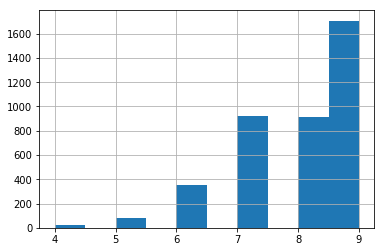

In [26]:
training_data_df[BEST_EPOCH].hist()

In [27]:
training_data_df[TOTAL_DURATION].describe()

count    4000.00000
mean      553.63750
std       115.50816
min       343.00000
25%       484.75000
50%       554.00000
75%       623.00000
max      2456.00000
Name: Total_Duration(s), dtype: float64

In [28]:
training_data_df.groupby([TRAINING_NUMBER]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Training_Number,,,,,,,,
4,400.0,0.812039,0.007604,0.778397,0.806900,0.811969,0.817108,0.828518
5,400.0,0.812008,0.008387,0.786631,0.806522,0.813231,0.818119,0.831003
0,400.0,0.811439,0.006939,0.787256,0.807227,0.812420,0.816554,0.825516
1,400.0,0.811156,0.007614,0.783002,0.805447,0.811063,0.817416,0.825660
2,400.0,0.811146,0.006390,0.789429,0.807340,0.811680,0.816097,0.824336
3,400.0,0.810700,0.006866,0.784046,0.805775,0.810906,0.815170,0.828209
6,400.0,0.809900,0.007869,0.782390,0.804677,0.810543,0.815689,0.826452
9,400.0,0.809423,0.007256,0.792208,0.804573,0.809178,0.814006,0.828776
8,400.0,0.809261,0.007236,0.787330,0.804827,0.809110,0.814562,0.825516


In [29]:
rp.summary_cont(training_data_df[TEST_F1_MEASURE])

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,Test_F1_Measure,4000.0,0.810514,0.007541,0.000119,0.810281,0.810748


In [30]:
rp.summary_cont(training_data_df.groupby(EMBEDDING))[TEST_F1_MEASURE]

,N,Mean,SD,SE,95% Conf.,Interval
Embedding,,,,,,
No,500,0.810585,0.007542,0.000337,0.809924,0.811246
fasttext,1000,0.807844,0.007929,0.000251,0.807352,0.808335
glove,500,0.812401,0.006804,0.000304,0.811804,0.812997
wang2vec,1000,0.812205,0.006863,0.000217,0.811779,0.812630
word2vec,1000,0.810517,0.007373,0.000233,0.810060,0.810974


In [31]:
# Calculating effect size
def anova_table(aov):
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']
    
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])
    
    cols = ['sum_sq', 'mean_sq', 'df', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov

def print_anova(parameter):
    # Fits the model with the interaction term
    # This will also automatically include the main effects for each factor
    model = ols('Test_F1_Measure ~ C({0})'.format(parameter), training_data_df).fit()
    # Seeing if the overall model is significant
    print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .20f}")
    print(model.summary())
    res = sm.stats.anova_lm(model, typ= 2)
    print(res)
    print(anova_table(res))
    mc = statsmodels.stats.multicomp.MultiComparison(training_data_df[TEST_F1_MEASURE], training_data_df[parameter])
    mc_results = mc.tukeyhsd()
    print(mc_results)

In [32]:
print_anova(EMBEDDING)

Overall model F( 4, 3995) =  54.520, p =  0.00000000000000000000
                            OLS Regression Results                            
Dep. Variable:        Test_F1_Measure   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     54.52
Date:                Fri, 27 Sep 2019   Prob (F-statistic):           8.14e-45
Time:                        15:20:42   Log-Likelihood:                 13981.
No. Observations:                4000   AIC:                        -2.795e+04
Df Residuals:                    3995   BIC:                        -2.792e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

In [33]:
print_anova(REPRESENTATION)

Overall model F( 3, 3996) =  25.830, p =  0.00000000000000015219
                            OLS Regression Results                            
Dep. Variable:        Test_F1_Measure   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     25.83
Date:                Fri, 27 Sep 2019   Prob (F-statistic):           1.52e-16
Time:                        15:20:42   Log-Likelihood:                 13913.
No. Observations:                4000   AIC:                        -2.782e+04
Df Residuals:                    3996   BIC:                        -2.779e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

In [34]:
training_data_df[(training_data_df.Embedding == 'wang2vec') & (training_data_df.Embedding_Type == 'skip') & (training_data_df.Representation == 'ELMo+Embeddings')]

,Training_ID,Model,Representation,Embedding,Embedding_Type,Training_Number,Execution_Number,Best_Epoch,Training_Epochs,Training_Duration,Total_Duration(s),Average_Epoch_Duration(s),Training_Accuracy,Training_Accuracy_Top-3,Training_Precision,Training_Recall,Training_F1-Measure,Training_Loss,Best_Validation_Accuracy,Best_Validation_Accuracy_Top-3,Best_Validation_Precision,Best_Validation_Recall,Best_Validation_F1-Measure,Best_Validation_Loss,Test_Accuracy,Test_Accuracy_Top-3,Test_Precision,Test_Recall,Test_F1_Measure,Test_Loss
623,harem-ft1epoch_ELMo+Embeddings_wang2vec_skip_0_1,harem-ft1epoch,ELMo+Embeddings,wang2vec,skip,0,1,8,10,0:07:59.563391,479.0,47.9,0.993316,0.993899,0.928065,0.918554,0.923285,59.097069,0.977926,0.980330,0.805897,0.836735,0.821026,186.269592,0.977291,0.979077,0.802213,0.798998,0.800602,229.160371
624,harem-ft1epoch_ELMo+Embeddings_wang2vec_skip_0_2,harem-ft1epoch,ELMo+Embeddings,wang2vec,skip,0,2,8,10,0:08:56.557806,536.0,53.6,0.993440,0.993999,0.927734,0.917476,0.922576,59.170702,0.979128,0.981423,0.804401,0.839286,0.821473,179.613590,0.977381,0.979197,0.806332,0.799332,0.802817,228.825894
625,harem-ft1epoch_ELMo+Embeddings_wang2vec_skip_0_3,harem-ft1epoch,ELMo+Embeddings,wang2vec,skip,0,3,8,10,0:10:30.035607,630.0,63.0,0.993719,0.994257,0.929915,0.919633,0.924746,58.516904,0.979019,0.981204,0.815271,0.844388,0.829574,183.602943,0.977366,0.979167,0.805995,0.798998,0.802482,231.091532
626,harem-ft1epoch_ELMo+Embeddings_wang2vec_skip_0_4,harem-ft1epoch,ELMo+Embeddings,wang2vec,skip,0,4,8,10,0:08:38.880011,518.0,51.8,0.993406,0.993988,0.926339,0.919094,0.922702,59.092602,0.978254,0.980658,0.809877,0.836735,0.823087,186.162399,0.977261,0.979092,0.802286,0.796661,0.799464,229.331091
627,harem-ft1epoch_ELMo+Embeddings_wang2vec_skip_1_0,harem-ft1epoch,ELMo+Embeddings,wang2vec,skip,1,0,8,10,0:09:10.339193,550.0,55.0,0.993894,0.994414,0.929501,0.922249,0.925861,58.648292,0.986258,0.987453,0.856423,0.887728,0.871795,133.558599,0.975760,0.977501,0.806901,0.812020,0.809452,246.304887
628,harem-ft1epoch_ELMo+Embeddings_wang2vec_skip_1_1,harem-ft1epoch,ELMo+Embeddings,wang2vec,skip,1,1,9,10,0:08:19.218081,499.0,49.9,0.993283,0.993860,0.923639,0.917676,0.920648,58.780010,0.987353,0.988449,0.864796,0.885117,0.874839,137.278025,0.978417,0.980158,0.822970,0.808681,0.815763,240.245235
629,harem-ft1epoch_ELMo+Embeddings_wang2vec_skip_1_2,harem-ft1epoch,ELMo+Embeddings,wang2vec,skip,1,2,9,10,0:09:35.900964,575.0,57.5,0.993690,0.994256,0.927913,0.921173,0.924531,59.061399,0.987552,0.988648,0.862595,0.885117,0.873711,137.825998,0.978552,0.980293,0.825467,0.811686,0.818519,244.555501
630,harem-ft1epoch_ELMo+Embeddings_wang2vec_skip_1_3,harem-ft1epoch,ELMo+Embeddings,wang2vec,skip,1,3,9,10,0:11:24.141196,684.0,68.4,0.993588,0.994142,0.926216,0.921980,0.924093,59.135724,0.987851,0.988946,0.869898,0.890339,0.880000,133.722347,0.977981,0.979797,0.827326,0.804674,0.815843,246.567333
631,harem-ft1epoch_ELMo+Embeddings_wang2vec_skip_1_4,harem-ft1epoch,ELMo+Embeddings,wang2vec,skip,1,4,9,10,0:09:15.624508,555.0,55.5,0.993396,0.994029,0.924513,0.919290,0.921894,58.281009,0.987652,0.988648,0.865482,0.890339,0.877735,139.050325,0.978206,0.979932,0.825289,0.810684,0.817922,245.614770
632,harem-ft1epoch_ELMo+Embeddings_wang2vec_skip_2_0,harem-ft1epoch,ELMo+Embeddings,wang2vec,skip,2,0,8,10,0:07:47.886636,467.0,46.7,0.993435,0.994003,0.921563,0.916230,0.918889,62.425644,0.981022,0.982076,0.825147,0.891720,0.857143,167.371662,0.976270,0.977981,0.806590,0.817362,0.811940,240.085055
